In [ ]:
!git clone https://github.com/ToelUl/Thermal-Phase-Transition-MC-GPU-Simulation.git

!cp -r Thermal-Phase-Transition-MC-GPU-Simulation/gpu_mc ./

In [1]:
import time
import matplotlib.pyplot as plt

from gpu_mc import IsingModel

import torch

if not torch.cuda.is_available():
    print("⚠️ GPU runtime is not enabled. Please go to 'Runtime' > 'Change runtime type' and set 'Hardware accelerator' to 'GPU'.")
else:
    print("✅ GPU runtime is enabled and ready!")

✅ GPU runtime is enabled and ready!


In [2]:
L = 16

T = torch.linspace(1.0, 3.5, steps=32)

sampler_ising = IsingModel(
    L=L,
    T=T,
    n_chains=30,
    device=torch.device("cuda"),
    use_amp=True,
    pt_enabled=False,
    )

start = time.time()
samples_ising = sampler_ising(n_sweeps=1000, n_therm=3000, decorrelate=10)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Elapsed time: 2.90 s


Samples shape: torch.Size([32, 3000, 16, 16])


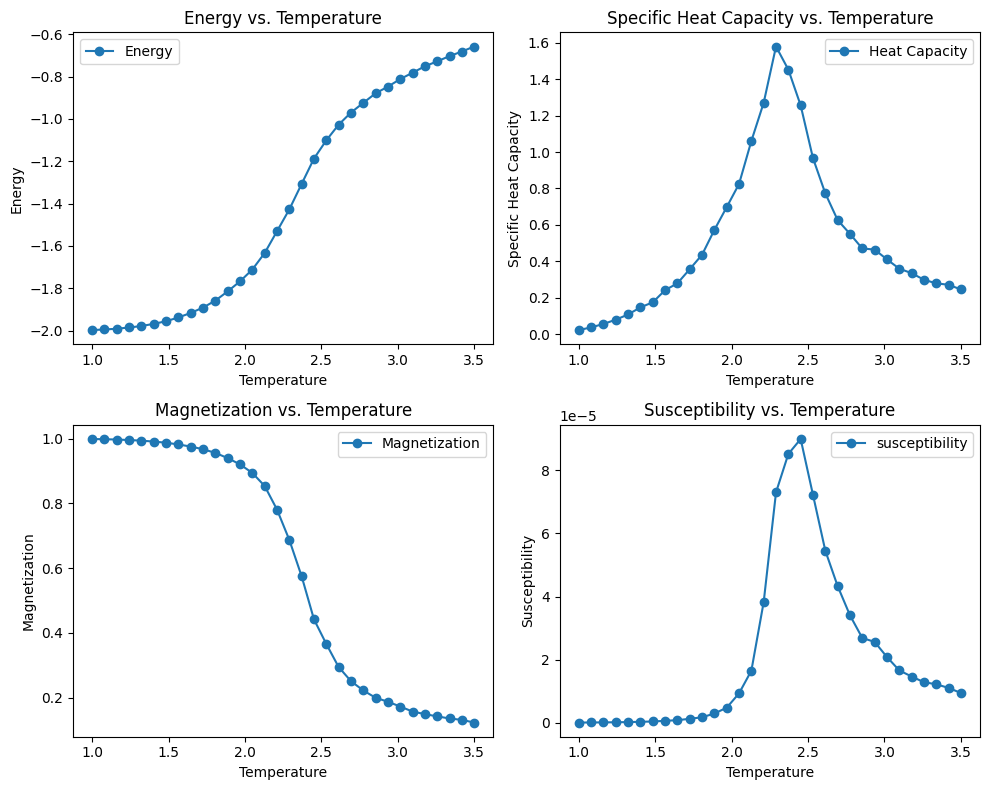

In [3]:
print(f"Samples shape: {samples_ising.shape}")

sampler_ising.spins = samples_ising

energy_ising = sampler_ising.compute_energy().mean(dim=1).cpu().numpy() / L**2
capacity_ising = sampler_ising.compute_heat_capacity().cpu().numpy()
magnetization_ising = sampler_ising.compute_magnetization().cpu().numpy()
susceptibility_ising = sampler_ising.compute_susceptibility().cpu().numpy()

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.plot(T.cpu().numpy(), energy_ising, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(222)
plt.plot(T.cpu().numpy(), capacity_ising, label='Heat Capacity', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Specific Heat Capacity')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(223)
plt.plot(T.cpu().numpy(), magnetization_ising, label='Magnetization', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(224)
plt.plot(T.cpu().numpy(), susceptibility_ising, label='susceptibility', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.tight_layout()
plt.show()